# CLEARER ARCHITECTURE

### damn, so this Slab model is not running as it should! 
and I am struggling to debug it reasonably.. which should really be the opposite! this can't be!

Additionally I want the ability to switch the background solver from GEKKO to odeint

## how to do this? 
- Solver, Time
- State Variables
- Forcings
- Fluxes

- Complex parameters are handled outside of xsimlab core, with helper functions

## It needs to be straighforward and easy to debug!
that is the main problem right now!

I need the ability to isolate each building block, and test it (i.e. give input/plot output), if necessary this can result in loss of flexibility!

In [ ]:
class PhydraCore:
 """ This core handles the necessary object types needed for a phydra model
         - Time
         - Solver
         
         - State Variables
         - Forcings
         - Fluxes
 """   


def SV():
    xs.variable()

In [1]:
import xsimlab as xs

In [9]:
def statevariable(*args,**kwargs):
    print(test)
    return xs.variable(*args,**kwargs)

In [11]:
wrap_xsvars(1,intent='out')

1


_CountingAttr(counter=23, _default=NOTHING, repr=False, eq=True, order=True, hash=None, init=False, metadata={'var_type': <VarType.VARIABLE: 'variable'>, 'dims': ((),), 'intent': <VarIntent.OUT: 'out'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}})

In [ ]:
@xs.process
class Solver:
    
    SVs = xs.group('SV')
    
    fluxes = xs.group('flux')
    
    
    

In [12]:
class Nutrient:
    """ """
    def __init__(self, solver):
        if solver == 'odeint':
            self.SV = 'N'
        elif solver == 'gekko':
            self.SV = GEKKO()
            

In [13]:
# 1. write simple model that works both with GEKKO & odeint

solver = 'odeint' # or 'gekko'

N = Nutrient(solver)
#P = Phytoplankton(solver)

In [15]:
N.SV

'N'

In [43]:
from gekko import GEKKO
import numpy as np

In [90]:
class StateVariable:
    """"""
    def __init__(self, *args, **kwargs):
        self.value = 1
        self.xsvar = xs.variable(*args,**kwargs)
        
    def value(self):
        
        
    def assemble_equations(self):
        
        self.m.Equation(
            self.SV.dt() == sum([flux for flux in self.fluxes])
        )


In [91]:
StateVariable(intent='out').xsvar

_CountingAttr(counter=132, _default=NOTHING, repr=False, eq=True, order=True, hash=None, init=False, metadata={'var_type': <VarType.VARIABLE: 'variable'>, 'dims': ((),), 'intent': <VarIntent.OUT: 'out'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}})

In [92]:
@xs.process
class Context:
    
    m = xs.any_object()
    
    def initialize(self):
        self.m = GEKKO()

In [93]:
@xs.process
class StateVariable:
    """ this process creates a single state variable with user specified label in our model """
    m = xs.foreign(Context, 'm')
    
    fluxes = xs.group('nutrient_flux')
    
    context = StateVariable(intent='out')
    
    label = xs.variable(intent='out')
    
    SV = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time', description='stores the value of component state variable')
    initVal = xs.variable(intent='in', description='initial value of component')

    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"state variable {self.label} is initialized")
        
        # store value in xarray here
        self.value = self.SV.value
        
        print(f"assembling equations for state variable {self.label}")
        
        self.SV.assemble_equation(self.fluxes)
        
        # store GEKKO SV object in Gekko context self.m


In [101]:
def phydra_model(solver, process_dict):
    """ This function wraps create_setup and adds a dummy clock parameter
    necessary for model execution """
    
    if solver == 'stepwise':
        process_dict.update({'Solver':StepWiseSolver})
        
    elif solver == 'gekko':
        process_dict.update({'Solver':GekkoSolver, 'Time':GekkoTime})
        
    elif solver == 'odeint':
        process_dict.update({'Solver':AdaptiveStepSolver, 'Time':AdaptiveStepTime})
        
    return xs.Model(process_dict)

In [94]:
model = xs.Model({'Context':Context,'Nutrient':StateVariable})
model

<xsimlab.Model (2 processes, 1 inputs)>
Context
Nutrient
    initVal     [in] initial value of component

In [98]:
def phydra_setup(model, solver, time, input_vars, output_vars):
    """ This function wraps create_setup and adds a dummy clock parameter
    necessary for model execution """
    if solver == 'stepwise':
        input_vars.update({'Time__time':time})
        return xs.create_setup(model=model,
                           # necessary for xsimlab
                           clocks={'time': time},
                           input_vars=input_vars,
                           output_vars=output_vars)
    
    elif solver == 'odeint':
        input_vars.update({'Time__time':time})
        return xs.create_setup(model=model,
                           # necessary for xsimlab
                           clocks={'clock': [0, 1]},
                           input_vars=input_vars,
                           output_vars=output_vars)
    elif solver == 'gekko':
        return xs.create_setup(model=model,
                           # necessary for xsimlab
                           clocks={'clock': [0, 1]},
                           input_vars=input_vars,
                           output_vars=output_vars)

In [99]:
df_in = phydra_setup(model, 
                    solver='stepwise',
                    time = np.arange(0,10),
                    input_vars = {
                        'Nutrient__initVal':1
                    },
                    output_vars = {
                         
                     }
                )

KeyError: "('Time', 'time') is/are not valid key(s) for input variables in model <xsimlab.Model (2 processes, 1 inputs)>\nContext\nNutrient\n    initVal     [in] initial value of component\n"

In [97]:
with model:
    df_out = df_in.xsimlab.run()

state variable Nutrient is initialized


AttributeError: '_CountingAttr' object has no attribute 'value'

# can I perhaps simply use the attrs (additional attributes) with xs.variables?

let's check:

In [ ]:

def statevariable(*args,**kwargs):
    
    @wrap(xs.variable)
    def 
    
    return
xs.variable()

In [13]:
import attr

In [137]:
from functools import wraps

# A couple helper functions first

def _qualname(obj):
    """Get the fully-qualified name of an object (including module)."""
    return obj.__module__ + '.' + obj.__qualname__

def _declaring_class(obj):
    """Get the name of the class that declared an object."""
    name = _qualname(obj)
    print(name)
    return name[:name.rfind('.')]

# Stores the actual visitor methods
_methods = {}

# Delegating visitor implementation
def _convertor_impl(self, arg):
    """Actual visitor method implementation."""
    method = _methods[(_qualname(type(self)), type(arg))]
    return method(self, arg)

# The actual @visitor decorator
def convertor(arg_type):
    """Decorator that creates a visitor method."""
    #@wraps(arg_type)
    def decorator(fn):
        declaring_class = _declaring_class(fn)
        _methods[(declaring_class, arg_type)] = fn

        # Replace all decorated methods with _visitor_impl
        return _convertor_impl

    return decorator

@attr.s
class StateVariable:
    name = attr.ib()
    initial_value = attr.ib()
    lb = attr.ib(default=0)

@attr.s
class Parameter:
    # usually constant
    name = attr.ib()
    value = attr.ib()

@attr.s
class Forcing:
    # usually changes over time
    name = attr.ib()
    value = attr.ib()
    
@attr.s
class Flux:
    name = attr.ib()
    args = attr.ib()
    equation = attr.ib()
    

import xsimlab as xs

from gekko import GEKKO

class GekkoContext:
    def __init__(self):
        self.m = GEKKO()

class GekkoConverter(GekkoContext):
    
    @convertor(StateVariable)
    def convert(self, obj):
        return self.m.SV(obj.initial_value, name=obj.name, lb=obj.lb).value
    
    @convertor(Parameter)
    def convert(self, obj):
        return self.m.Param(obj.value, name=obj.name)

    @convertor(Forcing)
    def convert(self, obj):
        # this should return m.Param, discretized
        return self.m.Param(obj.value, name=obj.name)

    @convertor(Flux)
    def convert(self, obj):
        return self.m.Intermediate(obj.equation, name=obj.name)

    
from collections import defaultdict

class OdeintContext:
    def __init__(self):
        self.SVs = defaultdict()
        self.Parameters = defaultdict()
        self.Forcings = defaultdict()
        self.Fluxes = defaultdict(list)
    
class OdeintConverter(OdeintContext):
    @convertor(StateVariable)
    def convert(self, obj):
        self.SVs[obj.name] = obj.initial_value
    
    @convertor(Forcing)
    def convert(self, obj):
        # this should return interpolated object, with time lookup
        self.Forcings[obj.name] = obj.initial_value

    @convertor(Forcing)
    def convert(self, obj):
        self.Forcings[obj.name] = obj.initial_value
    
    @convertor(Flux)
    def convert(self, obj):
        self.Fluxes[obj.name].append(obj.function)

__main__.GekkoConverter.convert
__main__.GekkoConverter.convert
__main__.GekkoConverter.convert
__main__.GekkoConverter.convert
__main__.OdeintConverter.convert
__main__.OdeintConverter.convert
__main__.OdeintConverter.convert
__main__.OdeintConverter.convert


In [138]:
_methods

{('__main__.GekkoConverter',
  __main__.StateVariable): <function __main__.GekkoConverter.convert(self, obj)>,
 ('__main__.GekkoConverter',
  __main__.Parameter): <function __main__.GekkoConverter.convert(self, obj)>,
 ('__main__.GekkoConverter',
  __main__.Forcing): <function __main__.GekkoConverter.convert(self, obj)>,
 ('__main__.GekkoConverter',
  __main__.Flux): <function __main__.GekkoConverter.convert(self, obj)>,
 ('__main__.OdeintConverter',
  __main__.StateVariable): <function __main__.OdeintConverter.convert(self, obj)>,
 ('__main__.OdeintConverter',
  __main__.Forcing): <function __main__.OdeintConverter.convert(self, obj)>,
 ('__main__.OdeintConverter',
  __main__.Flux): <function __main__.OdeintConverter.convert(self, obj)>}

In [143]:
def monod(ressource, consumer, halfsat):
    return ressource / (ressource + halfsat) * consumer

# TODO:

1. draw up the main differences between odeint and gekko solve
2. see how both can be integrated in a similar xsimlab process structure
3. draw up draft of new Phydra Core!


In [162]:
@xs.process
class Core:
    core = xs.any_object()

@xs.process
class GekkoCore(Core):
    
    def initialize(self):
        self.core = GekkoConverter()


@xs.process
class Nutrient:
    core = xs.foreign(Core, 'core')
    
    label = xs.variable(intent='out')
    
    initval = xs.variable(intent='in')
    
    SV = xs.variable(intent='out')
    
    value = xs.variable(intent='out')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        self.SV = self.core.convert(StateVariable(name=self.label, initial_value=self.initval))
        
        self.value = self.SV.value
        
        
        
    
    SV = StateVariable('Nutrient', 1.)

In [163]:
mod = xs.Model({'Core':GekkoCore, 'Nut':Nutrient})

mod

<xsimlab.Model (2 processes, 1 inputs)>
Core
Nut
    initval     [in]

In [158]:
in_ds = xs.create_setup(mod, 
                        clocks={'time':[0,1]},
                        input_vars={
                            'Nut__initval':1.,
                        }, 
                        output_vars={
                            'Nut__value':None,
                        })

in_ds

<xarray.Dataset>
Dimensions:       (time: 2)
Coordinates:
  * time          (time) int64 0 1
Data variables:
    Nut__initval  float64 1.0
Attributes:
    __xsimlab_output_vars__:  Nut__value

In [159]:
with mod:
    out_ds = in_ds.xsimlab.run()

IndexError: too many indices for array; expected 0, got 1

In [157]:
out_ds

<xarray.Dataset>
Dimensions:       (time: 2)
Coordinates:
  * time          (time) int64 0 1
Data variables:
    Nut__initval  float64 1.0

In [ ]:
import numpy as np
from gekko import GEKKO
from scipy.integrate import odeint
import matplotlib.pyplot as plt

m = GEKKO(remote=False)    # create GEKKO model

halfsat_const = m.Param(0.1)
N0 = m.Param(1.)
inflow_rate = m.Param(0.1)
mortality_rate = m.Param(0.1)

N = m.SV(1, lb=0)
P = m.SV(0.1, lb=0)

t = np.arange(0,10,.1)
m.time = t

# Growth under nutrient limitation is described via Monod / Michaelis-Menten kinetics
nutlim = m.Intermediate(N/(N+halfsat_const)*P)
N_influx = m.Intermediate(N0 * inflow_rate)
mortality = m.Intermediate(P * mortality_rate)

m.Equation(N.dt()==N_influx - nutlim)
m.Equation(P.dt()==nutlim - mortality)

m.options.NODES = 3
m.options.IMODE = 7


solve_start = tm.time()
m.solve(disp=False)
solve_end = tm.time()

m.cleanup()
print(f"Model was solved in {round(solve_end - solve_start, 2)} seconds")
    
plt.plot(m.time, N, label='N')
plt.plot(m.time, P, label='P')
plt.legend()

In [ ]:
def model()

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
def model(y,t):
    k = 0.3
    dydt = -k * y
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20)

# solve ODE
y = odeint(model,y0,t)

# plot results
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()

In [409]:

def _qualname(obj):
    """Get the fully-qualified name of an object (including module)."""
    return obj.__module__ + '.' + obj.__qualname__

def _declaring_class(obj):
    """Get the name of the class that declared an object."""
    name = _qualname(obj)
    print(name)
    return name[:name.rfind('.')]

# Stores the actual visitor methods
_methods = {}

# Delegating visitor implementation
def _convertor_impl(self, arg):
    """Actual visitor method implementation."""
    method = _methods[(_qualname(type(self)), type(arg))]
    return method(self, arg)

# The actual @visitor decorator
def convertor(arg_type):
    """Decorator that creates a visitor method."""
    #@wraps(arg_type)
    def decorator(fn):
        declaring_class = _declaring_class(fn)
        _methods[(declaring_class, arg_type)] = fn

        # Replace all decorated methods with _visitor_impl
        return _convertor_impl

    return decorator

@attr.s
class StateVariable:
    name = attr.ib()
    initial_value = attr.ib()
    lb = attr.ib(default=0)

@attr.s
class Parameter:
    # usually constant
    name = attr.ib()
    value = attr.ib()

@attr.s
class Forcing:
    # usually changes over time
    name = attr.ib()
    value = attr.ib()
    
@attr.s
class Flux:
    name = attr.ib()
    args = attr.ib()
    equation = attr.ib()
    

import xsimlab as xs

class OdeintConverter:
    
    @convertor(StateVariable)
    def convert(self, obj):
        return obj.initial_value
    
    @convertor(Parameter)
    def convert(self, obj):
        return obj.name, obj.value

    @convertor(Forcing)
    def convert(self, obj):
        # this should return m.Param, discretized
        return obj.value, obj.name

    @convertor(Flux)
    def convert(self, obj):
        return obj.equation, obj.name
    

from gekko import GEKKO

class GekkoContext:
    def __init__(self):
        self.gekko = GEKKO()

class GekkoConverter(GekkoContext):
    
    @convertor(StateVariable)
    def convert(self, obj):
        return self.gekko.SV(obj.initial_value, name=obj.name, lb=obj.lb)
    
    @convertor(Parameter)
    def convert(self, obj):
        return self.gekko.Param(obj.value, name=obj.name)

    @convertor(Forcing)
    def convert(self, obj):
        # this should return m.Param, discretized
        return self.gekko.Param(obj.value, name=obj.name)

    @convertor(Flux)
    def convert(self, obj):
        return self.gekko.Intermediate(obj.equation, name=obj.name)


__main__.OdeintConverter.convert
__main__.OdeintConverter.convert
__main__.OdeintConverter.convert
__main__.OdeintConverter.convert
__main__.GekkoConverter.convert
__main__.GekkoConverter.convert
__main__.GekkoConverter.convert
__main__.GekkoConverter.convert


In [431]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# to measure process time
import time as tm

In [558]:
class PhydraCore:
    def __init__(self):
        self.time = None
        self.SVs = defaultdict()
        self.Parameters = defaultdict()
        self.Forcings = defaultdict()
        self.Fluxes = defaultdict(list)
        
    def __repr__(self):
        return f"Model contains: \n SVs:{self.SVs} \n Params:{self.Parameters}\n Forcings:{self.Forcings}\n Fluxes:{self.Fluxes}"
        
        
    def odeint_solve(self):
        C = OdeintConverter()
        # here create function def model(y,t)
        
        y_labels = [label for label in self.SVs.keys()]
        y_values = [C.convert(SV) for SV in self.SVs.values()]
        
        print(self.Parameters)
        
        parameters = {Param.name:Param.value for Param in self.Parameters.values()}
        print(parameters)
        
        print(y_labels,y_values )
        
        fluxes = { label: flux
            for label, flux in zip(y_labels, self.Fluxes.values())}
        print(fluxes)
        
        
        def ode(c, t):
            state = {label: val for label, val in zip(y_labels, c)}
            return [sum(flux(state, parameters) for flux in fluxes[label]) for label in y_labels]
        
        if self.time is None:
            raise Exception('time needs to be supplied before solve')
            
        c_out = odeint(ode, y_values, self.time)
        #print(c_out)
        c_rows = (row for row in c_out.T)
        #print(c_rows)
        c_dict = {y_label:vals for y_label,vals in zip(y_labels, c_rows)}
        return c_dict
    
            
    def gekko_solve(self):
            
        C = GekkoConverter()
        # here create function def model(y,t)
        
        y_labels = [label for label in self.SVs.keys()]
        y_values = [C.convert(SV) for SV in self.SVs.values()]
        
        print(self.Parameters)
        
        parameters = {Param.name:Param.value for Param in self.Parameters.values()}
        print(parameters)
        
        print(y_labels,y_values )
        
        fluxes = { label: flux
            for label, flux in zip(y_labels, self.Fluxes.values())}
        print(fluxes)
        
        state = {label: val for label, val in zip(y_labels, y_values)}
            
        C.gekko.Equations(
            [SV.dt() == C.gekko.sum([flux(state, parameters) for flux in fluxes[SV.name]]) for SV in y_values]
        )
        
        if self.time is None:
            raise Exception('time needs to be supplied before solve')
            
        C.gekko.time = self.time
        
        C.gekko.options.IMODE = 7  # sequential dynamic solver
        
        print(C.gekko.__dict__)
        
        solve_start = tm.time()
        C.gekko.solve(disp=False)  # use option disp=True to print gekko output
        solve_end = tm.time()

        print(f"Model was solved in {round(solve_end - solve_start, 2)} seconds")

        return state
        
    
    

In [559]:
m = PhydraCore()

m.SVs['y'] = StateVariable(name='y', initial_value=5.)

m.Parameters['k'] = Parameter(name='k', value=0.5)

m.time = np.arange(1,20,0.1)

def linear(state,parameters):
    #print("LINEAR", state, parameters)
    y = state['y']
    k = parameters['k']
    dydt = -k*y
    return dydt

m.Fluxes['y'].append(linear)

m.Fluxes['y'].append(linear)

m

Model contains: 
 SVs:defaultdict(None, {'y': StateVariable(name='y', initial_value=5.0, lb=0)}) 
 Params:defaultdict(None, {'k': Parameter(name='k', value=0.5)})
 Forcings:defaultdict(None, {})
 Fluxes:defaultdict(<class 'list'>, {'y': [<function linear at 0x11bd81ee0>, <function linear at 0x11bd81ee0>]})

In [565]:
out_odeint = m.odeint_solve()

defaultdict(None, {'k': Parameter(name='k', value=0.5)})
{'k': 0.5}
['y'] [5.0]
{'y': [<function linear at 0x11bd81ee0>, <function linear at 0x11bd81ee0>]}


In [566]:
out_odeint

{'y': array([5.00000000e+00, 4.52418720e+00, 4.09365385e+00, 3.70409115e+00,
        3.35160031e+00, 3.03265338e+00, 2.74405826e+00, 2.48292660e+00,
        2.24664494e+00, 2.03284842e+00, 1.83939729e+00, 1.66435549e+00,
        1.50597113e+00, 1.36265903e+00, 1.23298488e+00, 1.11565085e+00,
        1.00948263e+00, 9.13417644e-01, 8.26494449e-01, 7.47843097e-01,
        6.76676410e-01, 6.12282125e-01, 5.54015772e-01, 5.01294196e-01,
        4.53589740e-01, 4.10424963e-01, 3.71367861e-01, 3.36027532e-01,
        3.04050280e-01, 2.75116067e-01, 2.48935310e-01, 2.25245979e-01,
        2.03810988e-01, 1.84415807e-01, 1.66866320e-01, 1.50986889e-01,
        1.36618588e-01, 1.23617614e-01, 1.11853845e-01, 1.01209545e-01,
        9.15781838e-02, 8.28633674e-02, 7.49778756e-02, 6.78427873e-02,
        6.13866926e-02, 5.55449767e-02, 5.02591735e-02, 4.54763810e-02,
        4.11487325e-02, 3.72329132e-02, 3.36897338e-02, 3.04837318e-02,
        2.75828217e-02, 2.49579693e-02, 2.25829050e-02, 2.0

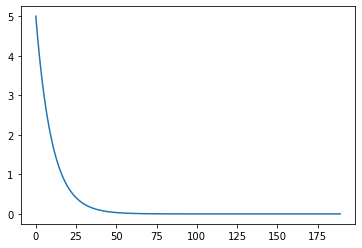

In [568]:
plt.plot(out_odeint['y'])

In [569]:
out_gekko = m.gekko_solve()

defaultdict(None, {'k': Parameter(name='k', value=0.5)})
{'k': 0.5}
['y'] [5.0]
{'y': [<function linear at 0x11bd81ee0>, <function linear at 0x11bd81ee0>]}
{'_remote': True, '_server': 'http://byu.apmonitor.com', 'options': <gekko.gk_global_options.GKGlobalOptions object at 0x11be5ed30>, '_id': 34, '_gui_open': False, '_constants': [], '_parameters': [], '_variables': [5.0, 0, 0, 0], '_intermediates': [], '_inter_equations': [], '_equations': [<gekko.gekko.EquationObj object at 0x11c009490>, <gekko.gekko.EquationObj object at 0x11c009250>, <gekko.gekko.EquationObj object at 0x11c009d90>], '_objectives': [], '_connections': ['v2 = sum_1.x[1]', 'v3 = sum_1.x[2]', 'v4 = sum_1.y'], '_objects': ['sum_1 = sum(2)'], '_compounds': [], '_raw': [], 'time': array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,

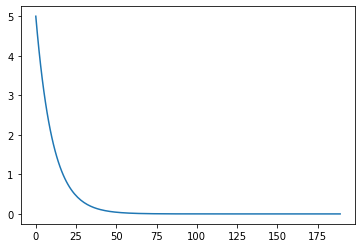

In [570]:
plt.plot(out_gekko['y'])

In [194]:
# SO SIMPLE MODEL RUNNING BOTH VIA GEKKO & ODEINT!
def model(y,t):
    k = 0.3
    dydt = -k * y
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20)

# solve ODE
y = odeint(model,y0,t)

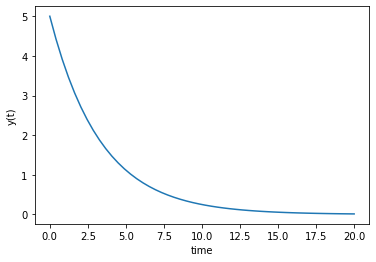

In [195]:
# plot results
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.show()

In [ ]:
@xs.process
class Nutrient:
    initial valu

In [170]:
# Simple Odeint XSIMLAB implementation

In [171]:
@xs.process
class StateVariable:
    initval = xs.variable(intent='in')
    
    fluxes = xs.group('SV_flux')
    
    value = xs.variable(intent='out')
    
    label = xs.variable(intent='out')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        
        self.value = self.initval
        
    def run_step(self):
        
        self.value = self.value * 0.1
        

In [172]:
xs.process_info(StateVariable)

<StateVariable  (xsimlab process)>
Variables:
    initval     [in]
    fluxes      [in] <--- group 'SV_flux'
    value      [out]
    label      [out]
Simulation stages:
    initialize
    run_step


# What are the absolute necessities:

- be able to use odeint (because it is way more efficient)

- solve on run_step with odeint, or allow step-wise solve through xsimlab

- gekko solve on run_step, not finalize_step! ==> equations need to be assembled at initialisation!
so perhaps the xs.group thing needs to be used for that!

So, how can I assemble GEKKO equations at init? initialize State Vars before (at model setup) OR assemble equations outside in another processs (using xs.group)

In [174]:
# how can I set up GEKKO state vars at model setup, instead of in initialize??

# Check the MODEL module in xsimlab

from xsimlab import Model

In [186]:
class PhydraModel(Model):
    
    def __init__(self, *args):
        print('hello')
        super(PhydraModel, self).__init__(*args)
    
    pass

In [187]:
@xs.process
class Test:
    value = xs.variable(intent='in')

In [188]:
PhydraModel({'T':Test})

hello


<xsimlab.Model (1 processes, 1 inputs)>
T
    value       [in]